In [1]:
using Pkg
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."))
push!(LOAD_PATH, joinpath(@__DIR__, "..", "..", "extras"))
Pkg.instantiate();

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


In [2]:
using Logging
with_logger(NullLogger()) do
    pkg"precompile"
end

Precompiling project...
Precompiling MechanismGeometries
Precompiling MeshCatMechanisms


In [3]:
using MeshCatMechanisms
using RigidBodyDynamics
using RigidBodyDynamics: Bounds, lower, upper

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [4]:
urdf = joinpath(dirname(pathof(RigidBodyDynamics)), "..", "test", "urdf", "Acrobot.urdf")
mechanism = parse_urdf(urdf, revolute_joint_type=SinCosRevolute{Float64})
shoulder, elbow = joints(mechanism);

In [5]:
τmax = 20.0 # 10.0
effort_bounds(shoulder) .= Bounds(0.0, 0.0)
effort_bounds(elbow) .= Bounds(-τmax, τmax);

In [6]:
@time mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
with_logger(NullLogger()) do
    open(mvis)
end

 13.864114 seconds (41.93 M allocations: 2.022 GiB, 8.79% gc time)


Process(`xdg-open http://127.0.0.1:8700`, ProcessExited(0))

In [7]:
using MINLPTrajOpt
using JuMP
using BARONTools

┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.0/MINLPTrajOpt/myGxE.ji for MINLPTrajOpt [c68a6224-cbe5-11e8-1e7f-b1d3117b2aa4]
└ @ Base loading.jl:1187


In [8]:
rootdir = joinpath(dirname(pathof(MINLPTrajOpt)), "..")
save_data = false;

In [9]:
using BARON

N = 40
objective = MinEffort()
T = objective isa MinEffort ? 4.5 : nothing
fixedstep = objective isa MinEffort

if fixedstep
    Δt = T / N
    Δtmin = Δt
    Δtmax = Δt
else
    Δtmin = 1e-3
    Δtmax = 0.5
end
Δθmax = 0.5#vmax * Δtmin

x0 = MechanismState(mechanism)
# set_configuration!(x0, shoulder, 0.05)
set_configuration!(x0, shoulder, 0.1)
set_configuration!(x0, elbow, 0.0)
zero_velocity!(x0)
# rand_configuration!(x0)

xf = MechanismState(mechanism)
set_configuration!(xf, shoulder, π)
set_configuration!(xf, elbow, 0.0)
zero_velocity!(xf)

solver = BaronSolver(threads=Sys.CPU_THREADS, MaxTime=10 * 60.0, PrTimeFreq=5.)
problem = TrajOptProblem(mechanism, x0, solver;
    xf=xf, Δtmin=Δtmin, Δtmax=Δtmax, T=T, N=N, Δθmax=Δθmax, objective=objective);

In [10]:
copyto!(mvis, x0)

In [11]:
solve(problem.model)

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  61.3384349539     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s) 

:Optimal

In [12]:
if save_data
    i = 0
    while (datadir = joinpath(rootdir, "data", "acrobot", "run$i"); isdir(datadir))
        global i
        i += 1
    end
    mkpath(datadir)
end
if save_data && solver isa BaronSolver
    cp(problem.model.internalModel.options[:SumName], joinpath(datadir, "sum.lst"))
end

In [13]:
ts = [0; cumsum(getvalue.(problem.Δts))]
q0 = configuration(x0)
qs = [broadcast!(getvalue, similar(q, Float64), q) for q in problem.qs]; pushfirst!(qs, q0)
Δqs = [broadcast!(getvalue, similar(Δq, Float64), Δq) for Δq in problem.Δqs]
vs = [broadcast!(getvalue, similar(v, Float64), v) for v in problem.vs];
τs = [broadcast!(getvalue, similar(τ, Float64), τ) for τ in problem.τs];

In [14]:
θ0 = map!(joint -> atan(q0[joint]...), similar(velocity(x0)), joints(mechanism))
Δθs = map(Δqs) do Δq
    map!(similar(velocity(x0)), joints(mechanism)) do joint
        s, c = Δq[joint]
        atan(s, c)
    end
end;
θs = cumsum([θ0, Δθs...]);

In [15]:
setanimation!(mvis, ts, qs)

┌ Warning: `getindex(itp::AbstractInterpolation{T, N}, i::Vararg{Number, N}) where {T, N}` is deprecated, use `itp(i...)` instead.
│   caller = #setanimation!#4(::Int64, ::Bool, ::Int64, ::Function, ::MechanismVisualizer{MechanismState{Float64,Float64,Float64,TypeSortedCollections.TypeSortedCollection{Tuple{Array{Joint{Float64,SinCosRevolute{Float64}},1}},1}},MeshCat.Visualizer}, ::Array{Float64,1}, ::Array{SegmentedVector{JointID,Float64,Base.OneTo{JointID},Array{Float64,1}},1}) at animate.jl:46
└ @ MeshCatMechanisms /home/twan/.julia/packages/MeshCatMechanisms/AHOtT/src/animate.jl:46


In [16]:
using LaTeXStrings
using PGFPlotsX
using PlottingTools
PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX);

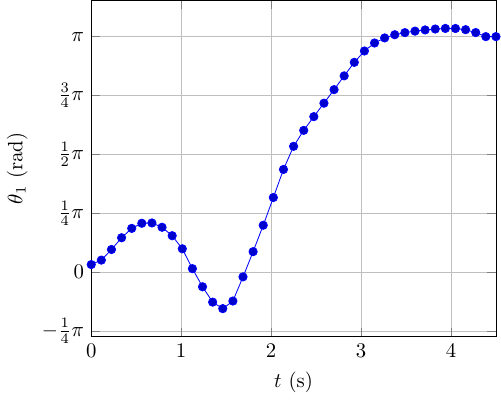

In [17]:
θshoulders = [θ[1] for θ in θs]
p = timeplot(ts, θshoulders; ylabel=L"$\theta_1$ (rad)", tmax=ts[end])
piticks!(p, 1//4, θshoulders; axis=:y)
p

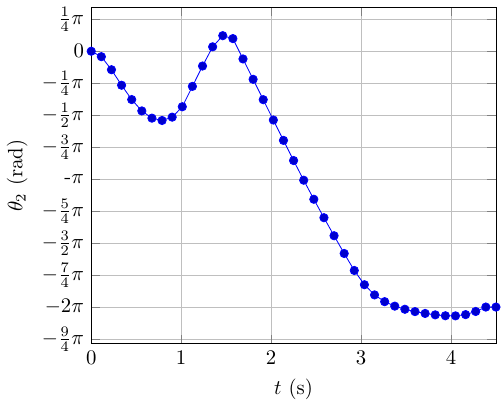

In [18]:
θ2s = [θ[2] for θ in θs]
p = timeplot(ts, θ2s; ylabel=L"$\theta_2$ (rad)", tmax=ts[end])
piticks!(p, 1//4, θ2s; axis=:y)
p

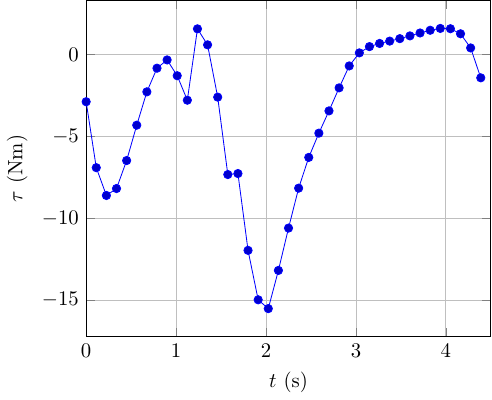

In [19]:
p = timeplot(ts[1 : end - 1], [first(τ[elbow]) for τ in τs]; ylabel=L"$\tau$ (Nm)", tmax=ts[end])
push!(p, @pgf HLine({dashed, red, thick}, upper(effort_bounds(elbow)[1])))
push!(p, @pgf HLine({dashed, red, thick}, lower(effort_bounds(elbow)[1])))
save_data && pgfsave(joinpath(datadir, "tau.pdf"), p)
p

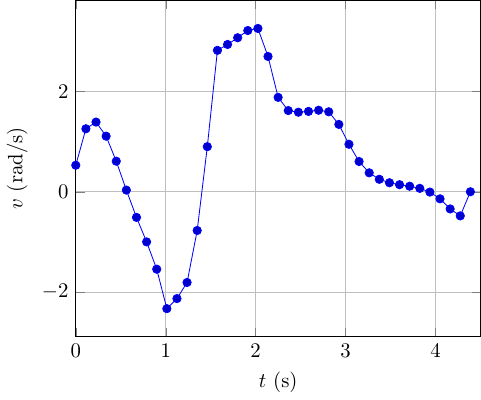

In [20]:
p = timeplot(ts[1 : end - 1], [first(v[shoulder]) for v in vs]; ylabel=L"$v$ (rad/s)", tmax=ts[end])